# Modified Neural Network

## Objective

The objective of this notebook is to modify the Neural Network that runs on custom tau and bias values and dataset. This customization aims to aid in understanding the model training process and the data flow within the network.

## Step 1: Import libraries and dataset

In [ ]:
#Import the dataset and other python libraries

!pip install reportlab

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import struct
import random
import math
import os
import json
import shutil
import sys
import sympy as sp

from tabulate import tabulate
from array import array
from os.path import join
from google.colab import files
from google.colab import drive
from zipfile import ZipFile
import zipfile
from google.colab import files
from io import StringIO
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader

def clear_seed():
    np.random.seed(None)
    random.seed(None)
    os.environ.pop('PYTHONHASHSEED', None)

# Call clear_seed at the beginning of the script
clear_seed()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.1 MB/s eta 0:00:00


In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def reset_seed():
    np.random.seed(None)
    random.seed(None)
    os.environ.pop('PYTHONHASHSEED', None)

In [ ]:
#This code handles the folders creation and saving results to review after the run

def create_run_folder(base_folder, run_number): # Create a folder for each run
    run_folder = os.path.join(base_folder, f"run_{run_number}")
    os.makedirs(run_folder, exist_ok=True)
    return run_folder


def save_results(folder_path, run_number, x_train,x_train_1, y_train, bias_values, tau_values, errors, final_bias_values, final_tau_values, output_text, subfolder_name=None):
    """
    Save the results under the specified folder path.
    If subfolder_name is None, files will be saved directly under the folder path.
    """
    # If subfolder_name is provided, create it under the folder path; otherwise, use the main folder path
    if subfolder_name:
        subfolder = os.path.join(folder_path, subfolder_name)
    else:
        subfolder = folder_path

    os.makedirs(subfolder, exist_ok=True)

    # Save x_train and y_train as .npy
    np.save(os.path.join(subfolder, "x_train.npy"), x_train)
    np.save(os.path.join(subfolder, "y_train.npy"), y_train)

     # Save x_train and y_train as CSV files
    pd.DataFrame(x_train).to_csv(os.path.join(subfolder, "x_train.csv"), index=False)
    pd.DataFrame(x_train_1).to_csv(os.path.join(subfolder, "x_train_1.csv"), index=False)
    pd.DataFrame(y_train).to_csv(os.path.join(subfolder, "y_train.csv"), index=False)

    # Save x_train and y_train as .json
    pd.DataFrame(x_train).to_json(os.path.join(subfolder, "x_train.json"))
    pd.DataFrame(y_train).to_json(os.path.join(subfolder, "y_train.json"))

    # Save bias_values and tau_values as .json
    with open(os.path.join(subfolder, "bias_values.json"), "w") as f:
        json.dump([b.tolist() for b in bias_values], f, indent=4)
    with open(os.path.join(subfolder, "tau_values.json"), "w") as f:
        json.dump([t.tolist() for t in tau_values], f, indent=4)

    # Save final bias_values and tau_values as .json
    with open(os.path.join(subfolder, "final_bias_values.json"), "w") as f:
        json.dump([b.tolist() for b in final_bias_values], f, indent=4)
    with open(os.path.join(subfolder, "final_tau_values.json"), "w") as f:
        json.dump([t.tolist() for t in final_tau_values], f, indent=4)

    # Save the errors array
    errors_file_path = os.path.join(subfolder, "errors.npy")
    np.save(errors_file_path, errors)
    with open(os.path.join(subfolder, "errors.json"), "w") as f:
        json.dump([b.tolist() for b in errors], f, indent=4)
    print(f"Errors saved to: {errors_file_path}")

    # Save the error plot
    plt.figure()
    plt.plot(range(1, len(errors) + 1), errors, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Error')
    plt.title('Error Rate Across Epochs')
    plt.savefig(os.path.join(subfolder, "error_plot.png"))
    plt.close()

    # Save console output as .json
    output_file_json = os.path.join(subfolder, "output.json")
    with open(output_file_json, "w") as f:
        json.dump({"output": output_text}, f, indent=4)

    # Save console output as .pdf
    output_file_pdf = os.path.join(subfolder, "output.pdf")
    save_output_as_pdf(output_text, os.path.join(subfolder, "error_plot.png"), output_file_pdf, run_number)

    # Copy parameters.json file to the run's subfolder
    original_parameters_path = "/content/DATA/parameters.json"
    parameters_destination_path = os.path.join(folder_path, "parameters.json")
    shutil.copyfile(original_parameters_path, parameters_destination_path)

def save_output_as_pdf(output_text, plot_file, file_path, run_number):
    c = canvas.Canvas(file_path, pagesize=letter)
    width, height = letter

    # Add a big title with the run number
    c.setFont("Helvetica-Bold", 20)
    c.drawString(50, height - 50, f"Run Number: {run_number}")

    # Add the console output text
    c.setFont("Helvetica", 10)
    x_margin = 50
    y_margin = height - 100
    line_height = 12

    lines = output_text.splitlines()
    y_position = y_margin
    for line in lines:
        if y_position < 50:  # start a new page if there's no more space
            c.showPage()
            y_position = height - 50
        c.drawString(x_margin, y_position, line)
        y_position -= line_height

    # Add the error plot to the PDF
    if os.path.exists(plot_file):
        c.showPage()  # Start a new page for the plot
        c.drawImage(ImageReader(plot_file), 100, 400, width=400, height=300)

    c.save()

def save_console_output(run_number, output_text, final_error, run_folder, is_bias_update=False):
    # Determine the subfolder based on whether it's a bias update or not
    subfolder_name = "bias_update_result" if is_bias_update else "original_result"
    run_folder_path = os.path.join(run_folder, subfolder_name)

    # Ensure the run_folder exists
    os.makedirs(run_folder_path, exist_ok=True)

    # Save console output as JSON
    output_file_json = os.path.join(run_folder_path, "output.json")
    with open(output_file_json, "w") as f:
        json.dump({"output": output_text}, f, indent=4)

    # Define the path to the existing error plot (if any)
    plot_file = os.path.join(run_folder_path, "error_plot.png")

    # Save console output as PDF
    output_file_pdf = os.path.join(run_folder_path, "output.pdf")
    save_output_as_pdf(output_text, plot_file, output_file_pdf, run_number)

In [ ]:
#Loads the particular data for specific re-run

def load_run_data(run_folder, base_folder):
    parameters_file_path = os.path.join(base_folder, "parameters.json")
    with open(parameters_file_path, "r") as file:
        parameters = json.load(file)

    num_training_inputs = parameters['num_training_inputs']
    lower_bound = parameters['lower_bound']
    max_lower_bound = parameters['max_lower_bound']
    upper_bound = parameters['upper_bound']
    min_upper_bound = parameters['min_upper_bound']
    func_expressions = parameters['func_expressions']
    num_layers = parameters['num_layers']
    num_neurons = parameters['num_neurons']
    epochs = parameters['epochs']
    bias_learning_rate = parameters['bias_learning_rate']
    tau_learning_rate = parameters['tau_learning_rate']
    # tau_bouncing_mode = parameters['tau_bouncing_mode']
    output_num_neurons =  parameters['output_num_neurons']
    num_input_neurons =  parameters['num_input_neurons']

    # Load x_train and y_train
    x_train = np.load(os.path.join(run_folder, "x_train.npy"))
    y_train = np.load(os.path.join(run_folder, "y_train.npy"))

    # Load bias_values and tau_values
    with open(os.path.join(run_folder, "bias_values.json"), "r") as f:
        bias_values = [np.array(b) for b in json.load(f)]
    with open(os.path.join(run_folder, "tau_values.json"), "r") as f:
        tau_values = [np.array(t) for t in json.load(f)]

    return num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_upper_bound, func_expressions, num_layers, num_neurons, num_input_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, x_train, y_train


In [ ]:

def rerun_specific_run(run_number, base_folder):
    set_seed(42)  # Set the seed only for reruns

    # Define the folder where the run data is stored
    run_folder = os.path.join(base_folder, f"run_{run_number}", 'original_result')

    if not os.path.exists(run_folder):
        print(f"Run folder for run number {run_number} does not exist.")
        return

    print(f"Rerunning run number: {run_number} from folder: {run_folder}")

    # Load data from the run folder
    num_training_inputs, lower_bound, max_lower_bound, upper_bound,min_upper_bound, func_expressions, num_layers, num_neurons, num_input_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, x_train, y_train = load_run_data(run_folder, base_folder)

    net = Network()
    output_num_neurons = num_neurons[-1] #added by KW - present in the original code, not sure the imapct of this change
    for i in range(num_layers):
        if i == num_layers - 1:  # last layer
            net.add(FCLayer(num_neurons[i], output_num_neurons, f'Layer {i+1}', bias=bias_values[i], tau=tau_values[i]))
        else:
            net.add(FCLayer(num_neurons[i], num_neurons[i + 1], f'Layer {i+1}', bias=bias_values[i], tau=tau_values[i]))
        net.add(ActivationLayer(ReLU))

    net.use(mse)

    # No capturing of console output, just printing everything to the console - not saving the results
    errors, final_bias_values, final_tau_values = net.fit(x_train, y_train, epochs, bias_learning_rate, tau_learning_rate)

    final_error = errors[-1]
    print(f"Re-Run of run number {run_number} completed with final error: {final_error}")

    reset_seed()

In [ ]:
# function to check if the last two epochs' error difference is constant
def is_error_stable(errors):
    # Set a tolerance level for floating-point comparisons
    tolerance = 1e-10

    # Ensure we have at least three error values to compare
    if len(errors) < 3:
        return False  # Not enough data to determine consistency

    # Calculate differences between consecutive error values
    print('error 1 :',errors[-1])
    print('error 2 :',errors[-2])
    print('error 3 :',errors[-3])
    diffs = np.diff(errors[-3:])

    # Case of stagnation: All differences are zero
    if np.all(np.abs(diffs) < tolerance):
      print('Error Status: Stagnant')
      return True

    return False

In [ ]:
# not used anywhere

def get_new_parameter_value(param_name):
    # Prompt the user for the new value of the specified parameter
    return float(input(f"Enter new value for {param_name}: "))

In [ ]:
"""
    Update parameters for a specific run and rerun the process with the new values.

    This function fetches the original data for the specified run number, updates parameters on the provided
    `new_value` flags, and then reruns the neural network training process with these updated parameters.

    Args:
        run_number (int): The number of the run to update.
        base_folder (str): The base directory where run data is stored.
        new_value (list of tuples): A list containing tuples that represent whether a parameter should be updated
                                     (1) or not (0), along with the new value for the parameter if it is to be updated.
                                     Format: [(bias_update_flag, new_bias_learning_rate),
                                              (tau_update_flag, new_tau_learning_rate),
                                              (taubounce_update_flag),
                                              (epochs_update_flag, new_epochs),
                                              (dataset_update_flag, new_dataset)].

    Returns:
        tuple: A tuple containing the run number and the rounded final error after rerunning the training.

    Raises:
        FileNotFoundError: If the original run data folder does not exist.

    Example:
        run_number = 2
        base_folder = "/path/to/data"
        new_value = [(1, 0.01), (0, None), (1, 'yes'), (1, 100), (0, None)]
        result = update_rerun_parameter(run_number, base_folder, new_value)
    """
# def update_rerun_parameter(run_number, base_folder, param_to_update, new_value):
def update_rerun_parameter(run_number, base_folder, new_value):

    run_folder = os.path.join(base_folder, f"run_{run_number}", 'original_result')
    if os.path.exists(run_folder):
       # Load the original data and parameters
      num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_upper_bound, func_expressions, num_layers, num_neurons, num_input_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, x_train, y_train = load_run_data(run_folder, base_folder)
      # Initialize debug_mode as 'no' by default
      debug_mode = 'no'

       # Create the folder structure for parameter updates
      # parameter_update_folder = os.path.join(base_folder, f"run_{run_number}", "parameter_update_result", f"{param_to_update}_result")
      parameter_update_folder = os.path.join(base_folder, f"run_{run_number}", "parameter_update_result")
      os.makedirs(parameter_update_folder, exist_ok=True)

      # Capture the console output
      original_stdout = sys.stdout
      sys.stdout = StringIO()

       # Update the specific parameter
      # if param_to_update == 'tau':
      #   tau_learning_rate = new_value
      # elif param_to_update == 'bias':
      #   bias_learning_rate = new_value
      # elif param_to_update == 'epochs':
      #   epochs = int(new_value)
      # elif param_to_update == 'taubounce':
      #   tau_bouncing_mode = new_value

      # Update the specific parameters based on the flags in new_value
      if new_value[0][0] == 1:  # Update bias learning rate
            bias_learning_rate = new_value[0][1]
      if new_value[1][0] == 1:  # Update tau learning rate
            tau_learning_rate = new_value[1][1]
      # if new_value[2][0] == 1:  # Update tau bouncing mode
      #       tau_bouncing_mode = new_value[2][1]
      if new_value[2][0] == 1:  # Update epochs
            epochs = int(new_value[2][1])
      if new_value[3][0] == 1:  # Update dataset
            # x_train, y_train = generate_data(num_neurons[0], "/content/DATA", True)
            x_train, y_train = generate_data(num_neurons[0], output_num_neurons, num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_upper_bound, func_expressions, "/content/DATA", True)
      if new_value[4][0] == 1:  # Enter the debug mode
            debug_mode = new_value[4][1]

      try:
        # Rerun the process for this specific run with the new parameters' value
        net = Network()
        for i in range(num_layers):
          if i == num_layers - 1:  # last layer
            net.add(FCLayer(num_neurons[i], output_num_neurons, f'Layer {i}', bias=bias_values[i], tau=tau_values[i]))
          else:
            net.add(FCLayer(num_neurons[i], num_neurons[i + 1], f'Layer {i}', bias=bias_values[i], tau=tau_values[i]))
          net.add(ActivationLayer(ReLU))

        net.use(mse)
        errors, final_bias_values, final_tau_values = net.fit(x_train, y_train, epochs, bias_learning_rate, tau_learning_rate, debug_mode)

        final_error = errors[-1]
        rounded_final_error = round(final_error, 2)

        # Save results directly in the update folder without the original_result subfolder
        save_results(parameter_update_folder, run_number, x_train,[], y_train, bias_values, tau_values, errors, final_bias_values, final_tau_values, sys.stdout.getvalue())

      finally:
                # Restore the original stdout
                sys.stdout = original_stdout

    else:
            print(f"Run folder for run number {run_number} does not exist.")

    # return new_run_summary
    return (run_number, rounded_final_error)


In [ ]:
"""
    Manage the rerunning or updating of neural network training parameters based on user input.

    This function prompts the user to decide whether to rerun an existing training run or update the parameters
    for all runs. It collects new parameter values if necessary, calls the `update_rerun_parameter` function to
    perform the rerun or update, and displays a comparison of errors before and after the update.

    Args:
        rerun_or_update (str): A string indicating the operation to perform; either 'rerun' or 'update'.
        base_folder (str): The base directory where the run data is stored.

    Returns:
        None: This function does not return a value but prints the results and comparison tables to the console.

    Raises:
        ValueError: If the user inputs an invalid run number or if binary input for updates is not valid.

    Example:
        manage_rerun_update("update", "/path/to/data")
    """

def manage_rerun_update(rerun_or_update, base_folder):

    new_run_summary = []
    # Initialize new_value to have 6 elements as (0, None)
    new_value = [(0, None) for _ in range(6)]

    if rerun_or_update == "rerun":
      rerun_number = int(get_valid_input( f"Enter the run number to update the parameters for (between 1 to {num_runs}): ", lambda x: validate_run_number(x, num_runs),
        f"Please enter a run number." ))
    update_type = get_valid_input(
    "Do you want to update the bias learning rate, tau learning rate, epochs, change the dataset, or enter debug mode? Enter binary digits (e.g., 01001) 0 = no, 1 = yes: ",
    validate_binary_string, "Invalid input. Please enter a 5-digit binary string like '01001'." )

    # Parse the binary flags (e.g., '0110' -> bias: 0, tau: 1, taubounce: 1, epochs: 0)
    for i, flag in enumerate(update_type):
      if flag == '1':
        if i == 0:
            new_bias_learning_rate = get_valid_input("Enter new value for bias learning rate: ", is_valid_number, "Invalid input.")
            new_value[i] = (1, float(new_bias_learning_rate))  # Assign to the correct index
        elif i == 1:
            new_tau_learning_rate = get_valid_input("Enter new value for tau learning rate: ", is_valid_number, "Invalid input.")
            new_value[i] = (1, float(new_tau_learning_rate))  # Assign to the correct index
        # elif i == 2:
        #     new_tau_bouncing_mode = get_valid_input("Tau Bouncing Mode (yes/no): ", validate_yes_no, "Enter either 'yes' or 'no'")
        #     new_value[i] = (1, new_tau_bouncing_mode)  # Assign to the correct index
        elif i == 2:
            new_epochs = get_valid_input("Enter new value for epochs: ", is_valid_number, "Invalid input.")
            new_value[i] = (1, int(new_epochs))  # Assign to the correct index
        elif i == 3:
            new_dataset = get_valid_input("Do you want to generate a new dataset? (yes/no): ", validate_yes_no, "Enter either 'yes' or 'no'")
            new_value[i] = (1, new_dataset)  # Assign to the correct index
        elif i == 4:
            new_debug = get_valid_input("Do you want to enter debug mode (yes/no): ", validate_yes_no, "Enter either 'yes' or 'no'")
            new_value[i] = (1, new_debug)  # Assign to the correct index

    if rerun_or_update == "update":
      for run_number in range(1, num_runs + 1):
        # run_summary_tuple = update_rerun_parameter(run_number, base_folder, param_to_update, new_value)
        run_summary_tuple = update_rerun_parameter(run_number, base_folder, new_value)
        new_run_summary.append(run_summary_tuple)

      print("Update completed with updated parameters.")

      # Generate comparison table
      headers = ["Former Run Number", "Former Error", "New Error"]
      comparison_table = [[i+1, former_run_summary[i][1], new_run_summary[i][1]] for i in range(len(new_run_summary))]
      print(tabulate(comparison_table, headers, tablefmt="grid"))

    elif rerun_or_update == "rerun":
      # run_summary_tuple = update_rerun_parameter(rerun_number, base_folder, param_to_update, new_value)
      run_summary_tuple = update_rerun_parameter(rerun_number, base_folder, new_value)
      new_run_summary.append(run_summary_tuple)

      print(f"Rerun for run number {rerun_number} completed with updated {update_type}.")

      # Generate comparison table using former_run_summary
      headers = ["Run Number", "Former Error", "New Error"]
      comparison_table = [[rerun_number, former_run_summary[rerun_number - 1][1], new_run_summary[0][1]]]
      print(tabulate(comparison_table, headers, tablefmt="grid"))


In [ ]:
#The clear_folders function is used to clear out a folder completely, removing all of its contents, and then recreating an empty folder with the same name

def clear_folders(base_folder):
    if os.path.exists(base_folder):
        shutil.rmtree(base_folder)
    os.makedirs(base_folder, exist_ok=True)

In [ ]:
#The zip_folder function compresses the contents of a folder into a ZIP file

def zip_folder(folder_path, zip_name):
    with ZipFile(zip_name, 'w') as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

In [ ]:
#Function to get user inputs - This function has two modes:
#it either loads existing parameters from a file or prompts the user to input new parameters
def get_input_with_default(prompt, default, data_type=str):
    user_input = input(f"{prompt} [{default}]: ")
    return data_type(user_input) if user_input else default


def get_user_inputs(create_new, run_number=1):
    folder_path = "/content/DATA"
    run_folder_path = os.path.join(folder_path, f"run_{run_number}")
    parameters_file_path = os.path.join(folder_path, "parameters.json")

    # Create the path to the parameters file within the specific run folder
    # parameters_file_path = os.path.join(run_folder_path, "parameters.json")

    if create_new and run_number == 1:
        print("Clearing existing files and creating new parameters...")
        clear_folders(folder_path)

    # if not create_new and os.path.exists(parameters_file_path):
    if not create_new:
      if os.path.exists(parameters_file_path):
            print(f"Loading parameters from {parameters_file_path} in common folder.")
      else:
        # If it doesn't exist in the common folder, check the run folder
        parameters_file_path = os.path.join(run_folder_path, "parameters.json")
        if os.path.exists(parameters_file_path):
                print(f"Loading parameters from {parameters_file_path} in run folder.")
        else:
                raise FileNotFoundError("Parameters file not found in either run or common folder.")

      with open(parameters_file_path, "r") as file:
          parameters = json.load(file)
      num_training_inputs = parameters['num_training_inputs']
      lower_bound = parameters['lower_bound']
      max_lower_bound = parameters['max_lower_bound']
      upper_bound = parameters['upper_bound']
      min_upper_bound = parameters['min_upper_bound']
      func_expressions = parameters['func_expressions']
      num_layers = parameters['num_layers']
      num_neurons = parameters['num_neurons']
      output_num_neurons =  parameters['output_num_neurons']
      epochs = parameters['epochs']
      bias_learning_rate = parameters['bias_learning_rate']
      tau_learning_rate = parameters['tau_learning_rate']
      bias_values = [np.array(bias) for bias in parameters['bias_values']]
      tau_values = [np.array(tau) for tau in parameters['tau_values']]

      folder_path = "/content/DATA"

      # return num_layers, num_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, tau_bouncing_mode, bias_values, tau_values, folder_path  # Ensure initial values are returned
      return num_training_inputs, lower_bound, max_lower_bound, upper_bound,min_upper_bound, func_expressions, num_layers, num_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, folder_path  # Ensure initial values are returned

    else:
        print("No parameters file found or user chose to create new parameters. Asking user for inputs...")

        # Ask for training data details
        num_training_inputs = get_input_with_default("Enter the number of training inputs (total number of samples) in the dataset", 50, int)
        num_input_neurons = get_input_with_default("Enter the number of neurons for the input layer (>=1)", 2, int)
        lower_bound = get_input_with_default("Enter the lower bound of input range", 0.0, float)
        max_lower_bound = get_input_with_default("Enter the max lower bound for input", 0.45, float)
        upper_bound = get_input_with_default("Enter the upper bound of input range", 1.0, float)
        min_upper_bound = get_input_with_default("Enter the min upper bound for input", 0.55, float)
        output_num_neurons = get_input_with_default("Enter the number of neurons for the output layer (>=1)", 2, int)

        # Collect function expressions before running
        func_expressions = []
        for i in range(output_num_neurons):
            func_str = input(f"Enter y_train({i+1}) function using symbols x0, x1, x2,...(use '&' for AND, '|' for OR): ")
            func_expressions.append(func_str)

        num_layers = get_input_with_default("Enter the total number of layers (>=2): ", 3, int)
        num_layers -= 2   # Subtracting input and output layers
        hidden_num_neurons = [int(input(f"Enter the number of neurons for layer {i+1}: ")) for i in range(num_layers)]
        num_neurons = [num_input_neurons] + hidden_num_neurons
        epochs = int(input("Enter the number of epochs: "))
        bias_learning_rate = get_input_with_default("Enter the bias learning rate : ", 5.0, float)
        tau_learning_rate = get_input_with_default("Enter the tau learning rate : ", 3.0, float)
        bias_values = []
        tau_values = []
        num_layers= num_layers+1
        # values_choice = input("Enter '0' to manually input values for bias and tau, or '1' to generate random values: ")
        values_choice = 1

        if values_choice == '0':
          #Input for layers except the output layer
            for i in range(1, num_layers):
                current_layer_neurons = num_neurons[i]
                previous_layer_neurons = num_neurons[i - 1]

                # Input for each neuron in the current layer
                layer_biases = []
                layer_taus = []

                for j in range(current_layer_neurons):
                    for k in range(previous_layer_neurons):
                        layer_biases.append(int(input(f"Enter bias value for hidden layer {i}, neuron {k+1}: ")))
                        layer_taus.append(float(input(f"Enter tau value for hidden layer {i}, neuron {k+1}: ")))

                #Reshape and append for layers except the last layer
                layer_biases = np.array(layer_biases).reshape(num_neurons[i], num_neurons[i-1])
                layer_taus = np.array(layer_taus).reshape(num_neurons[i], num_neurons[i-1])
                bias_values.append(layer_biases)
                tau_values.append(layer_taus)

            #Input for the output layer separately
            layer_biases = []
            layer_taus = []
            previous_layer_neurons = num_neurons[-2]

            for j in range(num_neurons[-1]):
                for k in range(previous_layer_neurons):
                    layer_biases.append(int(input(f"Enter bias value for output layer, neuron {k+1}: ")))
                    layer_taus.append(float(input(f"Enter tau value for output layer, neuron {k+1}: ")))

            #Reshape and append for the output layer
            layer_biases = np.array(layer_biases).reshape(output_num_neurons, num_neurons[-1])
            layer_taus = np.array(layer_taus).reshape(output_num_neurons, num_neurons[-1])
            bias_values.append(layer_biases)
            tau_values.append(layer_taus)

        else:
           #randomly initialized bias values
            bias_values = [np.random.randint(0, 2, (num_neurons[i + 1], num_neurons[i])) for i in range(num_layers - 1)]
            #Reshape and append bias for the output layer
            bias_values.append(np.random.randint(0, 2, (output_num_neurons, num_neurons[-1])))

            #randomly initialized tau values
            tau_values = [np.round(np.random.rand(num_neurons[i + 1], num_neurons[i]) * 0.8+0.1, decimals=1) for i in range(num_layers - 1)]
            #Reshape and append tau for the output layer
            tau_values.append(np.round(np.random.rand(output_num_neurons, num_neurons[-1]) * 0.8+0.1, decimals=1))


        #prepare a dictionary of parameters, save these parameters to a JSON file, and return them
        parameters = {
            'num_training_inputs': num_training_inputs,
            'lower_bound': lower_bound,
            'max_lower_bound': max_lower_bound,
            'upper_bound': upper_bound,
            'min_upper_bound': min_upper_bound,
            'func_expressions': func_expressions,
            'num_layers': num_layers,
            'num_neurons' : num_neurons,
            'num_input_neurons' : num_input_neurons,
            'output_num_neurons': output_num_neurons,
            'epochs': epochs,
            'bias_learning_rate': bias_learning_rate,
            'tau_learning_rate': tau_learning_rate,
            'bias_values': [b.tolist() for b in bias_values],  # Ensure 2D structure
            'tau_values': [t.tolist() for t in tau_values]
        }
        with open(parameters_file_path, "w") as file:
            json.dump(parameters, file, indent=4)

        # return num_layers, num_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, tau_bouncing_mode, bias_values, tau_values, folder_path
        return num_training_inputs, lower_bound,max_lower_bound, upper_bound,min_upper_bound, func_expressions, num_layers, num_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, folder_path

    return None

Afsaneh
Explanation for Different Cases for XOR function: Case 1: All inputs are the same

Example: [1, 1, 1] Sum: 3, which is odd XOR output: 3 % 2 = 1 This is because an odd number of 1s results in 1. Case 2: One input is different

Example: [1, 0, 1] Sum: 2, which is even XOR output: 2 % 2 = 0 This is because an even number of 1s results in 0. Case 3: All inputs are different

Example: [0, 1, 0] Sum: 1, which is odd XOR output: 1 % 2 = 1 This is because an odd number of 1s results in 1.

In [ ]:
# # Function to generate random inputs and compute outputs for AND, OR, XOR gates
# # def generate_data(num_input_neurons, output_num_neurons, folder_path, create_new):
# def generate_data(num_input_neurons, output_num_neurons, num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_upper_bound, func_expressions, folder_path, create_new):
#   x_train_file_path = os.path.join(folder_path, "x_train.npy")
#   y_train_file_path = os.path.join(folder_path, "y_train.npy")
#   print ('value for create_new from generate_data: ', create_new)

#   # Function to check if the operation is logical (like AND/OR)
#   def is_logical_operation(func_str):
#     logical_ops = ['&', '|', 'and', 'or']  # Add any other logical operators you want to support
#     return any(op in func_str for op in logical_ops)

#   print("x_train_file_path: ", x_train_file_path)
#   print("y_train_file_path: ", y_train_file_path)
#   if not create_new and os.path.exists(x_train_file_path) and os.path.exists(y_train_file_path):
#     #if os.path.exists(x_train_file_path) and os.path.exists(y_train_file_path):
#         print("Loading data from files...")
#         x_train = np.load(x_train_file_path)
#         y_train = np.load(y_train_file_path)
#   else:

#         # Create X_train dataset with random values uniformly between the bounds
#         x_train = np.random.uniform(lower_bound, upper_bound, (num_training_inputs, num_input_neurons))
#         # Apply limiting conditions
#         for i in range(num_input_neurons):
#             mask = np.random.choice([0, 1], size=num_training_inputs)

#             # Set values in the range [lower_bound, max_lower_bound]
#             x_train[:, i][mask == 0] = np.random.uniform(lower_bound, max_lower_bound, size=(mask == 0).sum())

#             # Set values in the range [min_upper_bound, upper_bound]
#             x_train[:, i][mask == 1] = np.random.uniform(min_upper_bound, upper_bound, size=(mask == 1).sum())
#         # Normalize the X_train data between 0 and 1
#         x_train = np.round(x_train, 2)

#         x_train_1=x_train

#         # x_train_min = x_train.min(axis=0)
#         # x_train_max = x_train.max(axis=0)
#         # x_train = (x_train - x_train_min) / (x_train_max - x_train_min)
#         # normalization
#         x_train = (x_train - lower_bound) / (upper_bound - lower_bound)

#         x_train = np.round(x_train, 2)

#         # Create y_train by asking user to provide functions for each output
#         y_train = []
#         x_symbols = sp.symbols(f'x0:{num_input_neurons}')  # Creates symbols x0, x1, x2, ..., up to num_inputs

#         # for i in  range(output_num_neurons):
#         for func_str in  func_expressions:
#           func = sp.sympify(func_str)  # Convert string to sympy expression
#           func_callable = sp.lambdify(x_symbols, func, 'numpy')  # Convert to callable

#           if is_logical_operation(func_str):
#             # Apply thresholding if the function is a logical operation
#             binary_x_train = (x_train > 0.5).astype(int)  # Convert to binary values based on threshold

#             # func = sp.sympify(func_str)  # Convert string to sympy expression
#             # func_callable = sp.lambdify(x_symbols, func, 'numpy')  # Convert to callable

#             # Evaluate the function for each row
#             y_values = np.array([func_callable(*binary_x_train[row]) for row in range(num_training_inputs)])
#             # y_values = np.array([func_callable(*x_train[row]) for row in range(num_training_inputs)])

#             # Convert boolean results to binary (0 and 1)
#             y_values = y_values.astype(int)

#           else:
#             # For mathematical functions, apply directly on continuous values
#             # func = sp.sympify(func_str)  # Convert string to sympy expression
#             # func_callable = sp.lambdify(x_symbols, func, 'numpy')  # Convert to callable
#             y_values = np.array([func_callable(*x_train[row]) for row in range(num_training_inputs)])
#             # def evaluate_row(row):
#             #         input_map = {f'x{i}': row[i] for i in range(len(row))}
#             #         return float(func.subs(input_map).evalf())

#             #     # Evaluate the function for each row
#             # y_values = np.array([evaluate_row(x_train[row]) for row in range(num_training_inputs)])


#           # Append results to y_train
#           y_train.append(y_values)

#       # Convert y_train to numpy array and transpose to match the format (num_training_inputs, num_outputs)
#         y_train = np.array(y_train).T

#         # print("\ny_train:")
#         # print(y_train)

#         # Save x_train and y_train to the folder path
#         # np.save(x_train_file_path, x_train)
#         # np.save(y_train_file_path, y_train)

#         # dataset_file_path = os.path.join(folder_path, "dataset.csv")
#         #dataset = pd.DataFrame(np.hstack((x_train, y_train)), columns=[f'Input_{i+1}' for i in range(num_input_neurons)] + ['AND', 'OR', 'XOR'])
#         # dataset = pd.DataFrame(np.hstack((x_train, y_train)), columns=[f'Input_{i+1}' for i in range(num_input_neurons)] + [f'Output_{i+1}' for i in range(output_num_neurons)])

#         # dataset.to_csv(dataset_file_path, index=False)

#   return x_train, y_train,x_train_1

# Function to generate random inputs and compute outputs for AND, OR, XOR gates
# def generate_data(num_input_neurons, output_num_neurons, folder_path, create_new):
def generate_data(num_input_neurons, output_num_neurons, num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_upper_bound, func_expressions, folder_path, create_new):
  x_train_file_path = os.path.join(folder_path, "x_train.npy")
  y_train_file_path = os.path.join(folder_path, "y_train.npy")
  print ('value for create_new from generate_data: ', create_new)

  # Function to check if the operation is logical (like AND/OR)
  def is_logical_operation(func_str):
    logical_ops = ['&', '|', 'and', 'or']  # Add any other logical operators you want to support
    return any(op in func_str for op in logical_ops)

  print("x_train_file_path: ", x_train_file_path)
  print("y_train_file_path: ", y_train_file_path)
  if not create_new and os.path.exists(x_train_file_path) and os.path.exists(y_train_file_path):
    #if os.path.exists(x_train_file_path) and os.path.exists(y_train_file_path):
        print("Loading data from files...")
        x_train = np.load(x_train_file_path)
        y_train = np.load(y_train_file_path)
  else:

        # Create X_train dataset with random values uniformly between the bounds
        x_train = np.random.uniform(lower_bound, upper_bound, (num_training_inputs, num_input_neurons))
        # Apply limiting conditions
        for i in range(num_input_neurons):
            mask = np.random.choice([0, 1], size=num_training_inputs)

            # Set values in the range [lower_bound, max_lower_bound]
            x_train[:, i][mask == 0] = np.random.uniform(lower_bound, max_lower_bound, size=(mask == 0).sum())

            # Set values in the range [min_upper_bound, upper_bound]
            x_train[:, i][mask == 1] = np.random.uniform(min_upper_bound, upper_bound, size=(mask == 1).sum())
        x_train_1=x_train
        x_train = np.round(x_train, 2)
        x_train = (x_train - lower_bound) / (upper_bound - lower_bound)
        # Create y_train by asking user to provide functions for each output
        y_train = []
        x_symbols = sp.symbols(f'x0:{num_input_neurons}')  # Creates symbols x0, x1, x2, ..., up to num_inputs

        # for i in  range(output_num_neurons):
        for func_str in  func_expressions:
          func = sp.sympify(func_str)  # Convert string to sympy expression
          func_callable = sp.lambdify(x_symbols, func, 'numpy')  # Convert to callable

          if is_logical_operation(func_str):
            # Apply thresholding if the function is a logical operation
            binary_x_train = (x_train > 0.5).astype(int)  # Convert to binary values based on threshold

            # func = sp.sympify(func_str)  # Convert string to sympy expression
            # func_callable = sp.lambdify(x_symbols, func, 'numpy')  # Convert to callable

            # Evaluate the function for each row
            y_values = np.array([func_callable(*binary_x_train[row]) for row in range(num_training_inputs)])
            # y_values = np.array([func_callable(*x_train[row]) for row in range(num_training_inputs)])

            # Convert boolean results to binary (0 and 1)
            y_values = y_values.astype(int)

          else:
            # For mathematical functions, apply directly on continuous values
            # func = sp.sympify(func_str)  # Convert string to sympy expression
            # func_callable = sp.lambdify(x_symbols, func, 'numpy')  # Convert to callable
            y_values = np.array([func_callable(*x_train[row]) for row in range(num_training_inputs)])

          # Append results to y_train
          y_train.append(y_values)

      # Convert y_train to numpy array and transpose to match the format (num_training_inputs, num_outputs)
        y_train = np.array(y_train).T

        # print("\ny_train:")
        # print(y_train)

        # Save x_train and y_train to the folder path
        # np.save(x_train_file_path, x_train)
        # np.save(y_train_file_path, y_train)

        # dataset_file_path = os.path.join(folder_path, "dataset.csv")
        #dataset = pd.DataFrame(np.hstack((x_train, y_train)), columns=[f'Input_{i+1}' for i in range(num_input_neurons)] + ['AND', 'OR', 'XOR'])
        # dataset = pd.DataFrame(np.hstack((x_train, y_train)), columns=[f'Input_{i+1}' for i in range(num_input_neurons)] + [f'Output_{i+1}' for i in range(output_num_neurons)])

        # dataset.to_csv(dataset_file_path, index=False)

  return x_train, y_train,x_train_1



In [ ]:
# def zip_files(zip_filename, folder_path): - not used anywhere
#     with ZipFile(zip_filename, 'w') as zipf:
#         for root, dirs, files in os.walk(folder_path):
#             for file in files:
#                 zipf.write(os.path.join(root, file), file)

In [ ]:
def get_valid_input(prompt, validation_fn, error_message):
    """
    General function to get validated user input.

    Parameters:
    - prompt: The message to display when asking for input.
    - validation_fn: A function that takes the input and returns True if it's valid, False otherwise.
    - error_message: The message to display when the input is invalid.

    Returns:
    - The validated input.
    """
    while True:
        user_input = input(prompt).strip().lower()
        if validation_fn(user_input):
            return user_input
        else:
            print(error_message)

#  validation functions for different input types
def validate_run_number(input_value, max_runs):
    try:
        run_number = int(input_value)
        return 1 <= run_number <= max_runs
    except ValueError:
        return False

# def validate_update_type(input_value):
#     valid_types = {"bias", "tau", "taubounce", "epochs"}
#     return input_value.lower() in valid_types

def validate_yes_no(input_value):
    return input_value.lower() in {"yes", "no"}

def is_valid_number(value):
    """Check if the input value can be converted to a valid number (int or float)."""
    try:
        num_value = float(value.strip())  # Convert to float
        return True
    except ValueError:
        return False

def validate_binary_string(input_str):    #This is a replacement for the validate_update_type function defined above.
    """Check if the input string is a 5-digit binary string (i.e., contains only '0' or '1')."""
    return len(input_str) == 5 and all(char in '01' for char in input_str)

def validate_rerun_or_update(input_value):
    """Check if the input value is one of the valid options."""
    return input_value in {"rerun", "update", "exit"}


## Step 2: Code the Base Class

Abstract Base Class Layer: This class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.

In [ ]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        self.bias = None
        self.tau = None
        self.z = None
        self.Z = None  # New attribute to store the value of Z
        self.constant = None  # New attribute to store the value of constant

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, bias_learning_rate, tau_learning_rate, epochs,Change_bias,Change_tau):
        raise NotImplementedError


## Step 3: Fully Connected Layer

The below piece of code defines a custom Fully Connected Layer (FCLayer) for a neural network. It inherits from a base class Layer (which is defined above) and includes methods for forward propagation and backward propagation.

**Forward propagation for each layer**

    Z(i) = self.Z * [{j=1to J} δ ((200 b (j, i) - 100) * (y(j) -  ζ (j, i))) - J + self.constant]
        
    y(i) = ReLU (Zi)


**Backward Propagation for each layer:**

*Calculate beta and theta*

    β(i,k) = self.Z *  δ' [(200 b(i, k) - 100) (yi - ζ (i , k))] * (200 b(i,k) - 100)

    θ (i, k) = self.Z *  δ' [(200 b(i, k) - 100) (yi - ζ (i , k))] * 200 * (yi - ζ (i, k))

*Calculate the gradients*

    ∇ b(i, k) =  { (yk – tk) * θ (i, k)}, if z(k) > 0

    ∇ b(i, k) =  { 0 }, if z(k) < 0

*Update the bias and tau*

    self.bias = self.bias + bias_gradient

    self.tau = self.tau + tau_gradient

In [ ]:
# inherit from base class Layer: Fully connected layer code
class FCLayer(Layer):

    def __init__(self, input_size, output_size, name, bias=None, tau=None):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.name = name  # Layer name
        self.bias = bias
        self.tau = tau

    # Set Z and constant based on the input_size
        if self.input_size >= 10:
            self.Z = 0.1
            self.constant = 10
        else :
            self.Z = round(1/self.input_size, 2)
            self.constant = self.input_size

    # returns output for a given input
    def forward_propagation(self, input_data):
        print(f"Forward propagation for : {self.name} with input neurons: {self.input_size} and output neurons: {self.output_size}")
        self.input = input_data
        print(f"input for the layer : {self.input} with tau: {self.tau} and bias: {self.bias}")

        # Ensure input and tau are reshaped to 1D arrays for element-wise comparison
        input_flat = self.input.flatten()
        tau_flat = self.tau.flatten()

        # Ensure that tau and input have the same size before comparison
        min_size = min(input_flat.size, tau_flat.size)
        input_flat = input_flat[:min_size]
        tau_flat = tau_flat[:min_size]

        # Use np.isclose to find indices where input and tau are approximately the same within a tolerance
        identical_indices = np.where(np.isclose(input_flat, tau_flat, atol=0.01))

        if identical_indices[0].size > 0:
            print(f"Identical input and tau detected at indices {identical_indices}. Updating input values.")

            # Loop through the indices where input and tau are close
            for idx in identical_indices[0]:
              if (0.6 <= tau_flat[idx] <= 1) or (0.4 <= tau_flat[idx] <= 0.5):  #between 0.6 to 1 OR between 0.4 and 0.5
                # Subtract 0.1 if tau is greater than 0.8
                input_flat[idx] -= 0.1
                print(f"Tau value at index {idx} is greater than 0.8. Subtracting 0.1 from input.")
              else:
                # Add 0.1 if tau is 0.8 or less
                input_flat[idx] += 0.1
                print(f"Tau value at index {idx} is less than or equal to 0.8. Adding 0.1 to input.")

            # Reshape input_flat back to original shape
            self.input = input_flat.reshape(self.input.shape)
            print(f"Updated input for the layer: {self.input} with tau: {self.tau} and bias: {self.bias}")

        #calculate z(i)
        self.z = self.Z * (np.sum(sigmoid((200 * self.bias - 100) * (self.input - self.tau)), axis = 1, keepdims=True) - self.input_size + self.constant)
        self.output =  self.z.T
        print(f"output after Forward Propagation : {self.output}")

        return self.output

    # computes thresholds - tau, tau_gradient and bias_gradient
    def backward_propagation(self, is_last_layer, layer_target_output, prev_tau_gradient, bias_learning_rate, tau_learning_rate, epochs,Change_bias,Change_tau):
        print(f"Backward propagation begins for : {self.name}")
        bias_learning_rate_modified = bias_learning_rate
        tau_learning_rate_modified = tau_learning_rate
        #calculate the beta and theta for the previous layer
        beta = self.Z * sigmoid_prime((2 * self.bias - 1) * (self.input - self.tau)) * (2 * self.bias - 1)
        theta = self.Z * sigmoid_prime((2 * self.bias - 1) * (self.input - self.tau)) * 2 * (self.input - self.tau)
        print('beta from BP: ',  beta)
        print('theta from BP: ',  theta)
        if Change_tau == True:
          tau_learning_rate_modified = tau_learning_rate - 1

        if Change_bias == True:
          bias_learning_rate_modified = bias_learning_rate - 2

        print('Effective Bias Learning rate = ', bias_learning_rate_modified)
        print('Effective Tau Learning rate = ', tau_learning_rate_modified)

        #calculate gradients based on layer
        print(' Calculate tau and bias gradients:')
        if is_last_layer:

            tau_gradient = np.round((layer_target_output - self.output).T * beta, decimals=2)
            tau_gradient = np.where(tau_gradient < 0.1, tau_gradient * tau_learning_rate_modified, tau_gradient)

            bias_gradient = (self.output - layer_target_output).T * theta
            bias_gradient = np.where(np.absolute(bias_gradient) < 0.05, bias_gradient , bias_gradient * bias_learning_rate_modified)

        else:
            tau_gradient = np.round(np.dot(np.sum(prev_tau_gradient, axis=0), beta), decimals = 2)
            tau_gradient = np.where(tau_gradient < 0.1, tau_gradient * tau_learning_rate_modified, tau_gradient)

            bias_gradient = np.dot(np.sum(prev_tau_gradient, axis=0), -theta)
            bias_gradient = np.where(np.absolute(bias_gradient) < 0.05, bias_gradient , bias_gradient * bias_learning_rate_modified)
            bias_gradient = np.where(bias_gradient > 1, 1, bias_gradient)

        #tau_gradient = np.clip(tau_gradient, -1, 1)
        print('tau_gradient from BP: ',  tau_gradient)
        print('bias_gradient from BP: ',  bias_gradient)

        #store the value of tau_gradient to be passed on to the next layer in BP
        prev_tau_gradient = tau_gradient

        # update bias and tau for the current layer
        print(' Update tau and bias values based on gradients:')

        self.tau = np.round(self.tau - tau_gradient, decimals=2)
        self.tau = np.where(
            np.logical_or(self.tau > 0.9, self.tau < 0.1),
            np.where(self.tau > 0.9, 0.9 - (self.tau - 0.9), 0.1 + (0.1 - self.tau)),
            # Limit the change to 0.2 for values within the range
            np.clip(self.tau, self.tau - 0.2, self.tau + 0.2)
            )

        self.bias = np.round(self.bias - bias_gradient, decimals=0)
        self.bias = np.clip(self.bias, 0, 1)

        print('self.tau after update from BP: ', self.tau)
        print('self.bias after update from BP: ',  self.bias)
        print(f"Backward propagation ends for : {self.name}")

        return prev_tau_gradient

## Step 4: Activation Layer

In a neural network, an activation layer introduces non-linearity to the model. The Relu is implemented in this layer which returns the activated input: y(i) = ReLU (Zi) which is the final output for the layer. For the backward propagation, the activation layer is not used in the modified NN.

*This can be further edited by removing it and directly integrating the Relu function into the forward propagation within the FC layer class. The activation layer has been defined separately to enhance clarity in the network structure.*

In [ ]:
# inherit from base class Layer: Activation Layer code
class ActivationLayer(Layer):
    def __init__(self, activation):
        super().__init__()
        self.activation = activation

    # returns the activated input: y(i) = ReLU (Zi)

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        print('output for the layer after ReLu (y): ', self.output)
        return self.output

    # Not returning anything for the modified NN
    def backward_propagation(self, is_last_layer, layer_target_output, prev_tau_gradient, bias_learning_rate, tau_learning_rate, epochs,Change_bias,Change_tau):
        _ = self.activation(self.input)
        return prev_tau_gradient

In [ ]:
# updated activation function and its derivative
def ReLU(x):
    return np.maximum(0, x)

# Modified Sigmoid activation function used in FP
def sigmoid(x, alpha=1):
    x = x.astype(float)
    return 1 / (1 + np.exp(-alpha * x))

# Modified Derivative of Sigmoid activation function used in BP
def sigmoid_prime(x, alpha=1):
    sig_prime_1 = (1 - sigmoid(x, alpha))
    sig_prime_2 = sigmoid(x, alpha)
    return alpha * sigmoid(x, alpha) * (1 - sigmoid(x, alpha))

#Softmax Function for the last layer - used for classification tasks
def softmax(x, alpha=1):
    sig_prime_1 = (1 - sigmoid(x, alpha))
    sig_prime_2 = sigmoid(x, alpha)
    return alpha * sigmoid(x, alpha) * (1 - sigmoid(x, alpha))

## Step 5: Loss Function

Mean Squared Error (MSE) Loss Function: The mse function calculates the mean of the squared differences between the true values (y_true) and the predicted values (y_pred). It quantifies the average magnitude of the errors.

*This is solely for visualizing the model training, and the values are not directly utilized in the backward propagation.*

In [ ]:
# loss function: Used to visualize the model learning - error after each epoch
def mse(y_true, y_pred):
    return np.mean(np.power(np.squeeze(y_true) - np.squeeze(y_pred), 2))

## Step 6: Network Layer
The below code defines a basic neural network class named Network.

init Method: Initializes the neural network with an empty list of layers and placeholders for the loss function and its derivative.

add Method: Adds a layer to the neural network.

use Method: Sets the loss function

predict Method: Predicts the output for a given input by performing forward propagation through all the layers.

fit Method: Trains the neural network on the provided training data (x_train, y_train) using a specified number of epochs and learning rate. It includes a training loop that iterates through each epoch and sample, performing forward and backward propagation for each sample. The loss is computed during training for display purposes.

In [ ]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss):
        self.loss = loss

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samplesnp
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
              output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, bias_learning_rate, tau_learning_rate, debug_mode='no'):

        # sample dimension first
        prev_tau_gradient = None
        samples = len(x_train)
        errors = []  # List to store average errors for plotting

        Skip_tau_change = False

        # Track errors for the last 3 epochs to adjust bias learning rate
        last_3_errors = []
        lowest_error = float('inf')
        best_tau_values = []  # To track tau values corresponding to the lowest error
        best_bias_values = []  # To track tau values corresponding to the lowest error
        adjusted_bias_learning_rate = False
        initial_bias = bias_learning_rate  # Store the initial bias value

        # training loop
        for i in range(epochs):
            Change_tau = False
            Change_bias = False
            print(f"For epoch {i+1}, bias learning rate = {bias_learning_rate}")

            pi_va=np.pi/2

            print(f"For epoch {i+1}, skipping tau change = {Skip_tau_change}")
            err = 0  # Reset error for the current epoch
            print(f"For epoch {i+1}, Change_tau Prior to check= {Change_tau}, and Change_bias = {Change_bias}")
            if ((i % 2 != 0) or (i > 4 and not Skip_tau_change)):
                Change_tau = True
                Skip_tau_change = False
            if ((i % 2 == 0) or (i > 4)):
                Change_bias = True  # Check if the epoch is even
            print(f"For epoch {i+1}, Change_tau = {Change_tau}, and Change_bias = {Change_bias}")
            for j in range(samples):

                # forward propagation

                # updated val based on calculations
                output = x_train[j]*pi_va

                for layer in self.layers:
                    output = layer.forward_propagation(output)

                sample_err = self.loss(y_train[j], output)
                err += sample_err
                print(f'Epoch {i+1}, Sample {j+1}, Error: {sample_err}')


                #backward propagation
                print(f" *** Backward propagation Begins *** ")
                for layer in reversed(self.layers):
                    is_last_layer = (layer == self.layers[-2])  # Check if it's the last layerindex
                    prev_tau_gradient = layer.backward_propagation(is_last_layer, y_train[j], prev_tau_gradient, bias_learning_rate, tau_learning_rate, epochs,Change_bias,Change_tau)
                print(f" *** End of Backward propagation *** \n")

                # forward propagation - once again FP only for debug mode
                if debug_mode in ["yes", "y"]:
                  print(f" *** Forward propagation 2 Begins for the same input *** ")
                  for layer in self.layers:
                    output = layer.forward_propagation(x_train[j])

                  sample_err = self.loss(y_train[j], output)
                  err += sample_err
                  print(f'Epoch {i+1}, Sample {j+1}, Error: {sample_err}')
                  print(f" *** End of Forward propagation 2 *** \n")

            # calculate average error on all samples
            print(f" *** End of epoch: {i+1} ***")
            avg_err = err / samples
            errors.append(avg_err)
            print('Epoch %d/%d,   Average Error: %f \n' % (i+1, epochs, avg_err))

            # Track the lowest error and associated tau values
            if avg_err < lowest_error:
              lowest_error = avg_err
              for layer in self.layers:
                # if isinstance(layer, FCLayer):
                    best_bias_values.append(np.copy(layer.bias))
                    best_tau_values.append(np.copy(layer.tau))
                    print(f" Saving the tau value {best_tau_values} ")
                    print(f"Saving the bias value {best_bias_values}")

            # Check if the last 3 errors are constant or increasing
            last_3_errors.append(avg_err)
            if len(last_3_errors) > 3:
                last_3_errors.pop(0)  # Keep only the last 3 errors

              #  if len(last_3_errors) == 3 and last_3_errors[0] < last_3_errors[-1]:
              #   print(f"Error increasing/constant over last 3 epochs. Reverting to best tau and bias values observed so far.")
              #   for layer, best_tau, best_bias in zip(self.layers, best_tau_values, best_bias_values):
              #     # if isinstance(layer, FCLayer):
              #         layer.tau = np.copy(best_tau)
              #         layer.bias = np.copy(best_bias)
              #         print(f" Adjusted tau value {layer.tau} ")
              #         print(f"Adjusted bias value {layer.bias}")

                  # Error is increasing or constant, adjust learning rate
                Skip_tau_change = True
                if not adjusted_bias_learning_rate:
                    bias_learning_rate += 1
                    adjusted_bias_learning_rate = True
                    print(f"Adjusting bias learning rate to {bias_learning_rate} for Epoch {i+1}")

        # Save final bias and tau values
        final_bias_values = [layer.bias for layer in self.layers if isinstance(layer, FCLayer)]
        final_tau_values = [layer.tau for layer in self.layers if isinstance(layer, FCLayer)]

        # Plotting error rates across epochs
        plt.plot(range(1, epochs + 1), errors, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Average Error')
        plt.title('Error Rate Across Epochs')
        plt.show()

        return errors, final_bias_values, final_tau_values

## Step 7: Run \_\_main\_\_

In [ ]:

# Main function

if __name__ == "__main__":
    base_folder = "DATA"
    clear_folders(base_folder)  # Clear previous data
    create_new = True #by default always create new dataset when running the program for the 1st run

    debug_mode = input("Do you want to enter debug mode? (yes/no): ").strip().lower()
    upload_mode = input("Do you want to upload existing run folder? (yes/no): ").strip().lower()
    if upload_mode == 'yes':
      # Step 2: Upload the compressed folder (.zip file)
      print("Please upload a .zip file containing the folder.")
      uploaded = files.upload()  # Prompts user to upload files

      # Assuming only one file is uploaded, get its name
      zip_filename = list(uploaded.keys())[0]

      # Step 3: Extract the .zip to /content/DATA/
      extract_path = '/content/DATA/'
      os.makedirs(extract_path, exist_ok=True)  # Ensure the destination directory exists

      with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        # Extract the entire folder (e.g., 'run_3') to '/content/DATA/run_3/'
          zip_ref.extractall(extract_path)
          print(f"Folder '{zip_filename}' has been extracted to '{extract_path}'.")

          # Get the list of folders inside the extracted directory
          extracted_folders = [f for f in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, f))]

          # Assuming only one folder exists (e.g., 'run_3'), get the folder name
          if len(extracted_folders) == 1:
              extracted_folder = extracted_folders[0]
              print(f"Detected extracted folder: {extracted_folder}")

              # Locate parameters.json file inside the extracted folder (e.g., 'run_3')
              parameters_file_path_in_run = os.path.join(extract_path, extracted_folder, 'parameters.json')
              # Check for x_train.npy and y_train.npy in the extracted folder
              x_train_file_path_in_run = os.path.join(extract_path, extracted_folder,'original_result', 'x_train.npy')
              y_train_file_path_in_run = os.path.join(extract_path, extracted_folder,'original_result', 'y_train.npy')


              # If parameters.json exists, copy it to /content/DATA/ directory
              if os.path.exists(parameters_file_path_in_run):
                  shutil.copy(parameters_file_path_in_run, os.path.join(extract_path, 'parameters.json'))
                  print(f"'parameters.json' has been copied to '{extract_path}'.")
              else:
                  print("No 'parameters.json' file found in the extracted folder.")

              # If x_train.npy exists, copy it to the common folder
              if os.path.exists(x_train_file_path_in_run):
                  shutil.copy(x_train_file_path_in_run, os.path.join(extract_path, 'x_train.npy'))
                  print(f"'x_train.npy' has been copied to '{extract_path}'.")
              else:
                  print("No 'x_train.npy' file found in the extracted folder.")

              # If y_train.npy exists, copy it to the common folder
              if os.path.exists(y_train_file_path_in_run):
                  shutil.copy(y_train_file_path_in_run, os.path.join(extract_path))
                  print(f"'y_train.npy' has been copied to '{extract_path}'.")
              else:
                  print("No 'y_train.npy' file found in the extracted folder.")

          else:
              print("Error: More than one folder was extracted. Unable to locate the run folder.")

    num_runs = int(input("Enter the number of runs: ").strip())
    run_summary = []

    for run_number in range(1, num_runs + 1):
        print ('run_number: ', run_number)

        # Create a folder for this run
        run_folder = create_run_folder(base_folder, run_number)

        # Capture the console output
        original_stdout = sys.stdout
        sys.stdout = StringIO()

        try:
            if upload_mode == "yes":
              num_training_inputs, lower_bound,max_lower_bound, upper_bound,min_upper_bound, func_expressions, num_layers, num_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, folder_path = get_user_inputs(False, run_number)
              x_train, y_train = generate_data(num_neurons[0], output_num_neurons, num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_upper_bound, func_expressions, folder_path, False)
            else:
              num_training_inputs, lower_bound,max_lower_bound, upper_bound,min_upper_bound, func_expressions, num_layers, num_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, folder_path = get_user_inputs(create_new if run_number == 1 else False, run_number)
              x_train, y_train,x_train_1 = generate_data(num_neurons[0], output_num_neurons, num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_upper_bound, func_expressions, folder_path, create_new)

            net = Network()
            for i in range(num_layers):
                if i == num_layers - 1:  # last layer
                    net.add(FCLayer(num_neurons[i], output_num_neurons, f'Layer {i+1}', bias=bias_values[i], tau=tau_values[i]))
                else:
                    net.add(FCLayer(num_neurons[i], num_neurons[i + 1], f'Layer {i+1}', bias=bias_values[i], tau=tau_values[i]))
                net.add(ActivationLayer(ReLU))

            net.use(mse)

            print(f"Run number: {run_number}")
            # Train the network



            errors, final_bias_values, final_tau_values = net.fit(x_train, y_train, epochs, bias_learning_rate, tau_learning_rate, debug_mode)

            # Check final error rate and save results in the appropriate folder
            final_error = errors[-1]
            print(f'Final Error: {final_error}')  # Debug statement to check the final error

            rounded_final_error = round(final_error, 2)
            if rounded_final_error == 0.00:
                rounded_final_error = 0
            run_summary.append((run_number, rounded_final_error))

            # Capture the console output to save
            output_text = sys.stdout.getvalue()

            # Save results in the run folder
            save_results(run_folder, run_number, x_train,x_train_1, y_train, bias_values, tau_values, errors, final_bias_values, final_tau_values, output_text, subfolder_name="original_result")

        finally:
            # Restore the original stdout
            sys.stdout = original_stdout

        # Save the output to JSON and PDF
        save_console_output(run_number, output_text, rounded_final_error, run_folder, None)

    # Print summary
    print("\nRun Summary:")
    headers = ["Run", "Final Error"]
    table = [[run_number, error] for run_number, error in run_summary]
    print(tabulate(table, headers, tablefmt="grid"))

    # Store former run summary before rerunning with updated bias
    former_run_summary = run_summary.copy()

    while True:
        rerun_or_update = get_valid_input( "\nDo you want to rerun a run number or update the parameters? (rerun/update/exit): ",
    validate_rerun_or_update, "Invalid input. Please enter 'rerun', 'update', or 'exit'." )

        if rerun_or_update == "exit":
            print("Exiting the program.")
            break

# int(sin(x0) + cos(x1))
# int(cos (x0 + x1))
# np.floor(sin(x0) + cos(x1))
# np.floor(cos (x0 + x1))

# np.floor(np.sin(x0) + np.cos(x1))
# np.floor(np.cos(x0 + x1))

# sp.floor(sp.sin(x0) + sp.cos(x1))
# sp.floor(sp.cos(x0 + x1))

# floor(sin(x0) + cos(x1))
# floor(cos (x0 + x1))


# floor(sin(x0)+cos(x1)+sin(x2)+cos(x3)+sin(x4)+cos(x5))
# floor(cos(x0+x1+x2+x3+x4+x5))

# floor( (sin(x0)+cos(x1)+sin(x2)+cos(x3)+sin(x4)+cos(x5) )/6 )
# floor(cos(x0+x1+x2+x3+x4+x5)*(3.14/2)/6)

# *( PI()/2))/6
        else:

          manage_rerun_update(rerun_or_update, base_folder)

In [ ]:
    num_runs = 5
    # num_layers = 6
    for run_number in range(1, num_runs + 1):
        print ('run_number: ', run_number)

        # Create a folder for this run
        # run_folder = create_run_folder(base_folder, run_number)

        # Capture the console output
        # original_stdout = sys.stdout
        # sys.stdout = StringIO()

        try:
            # if upload_mode == "yes":
            #   num_training_inputs, lower_bound,max_lower_bound, upper_bound,min_upper_bound, func_expressions, num_layers, num_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, folder_path = get_user_inputs(False, run_number)
            #   x_train, y_train = generate_data(num_neurons[0], output_num_neurons, num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_upper_bound, func_expressions, folder_path, False)
            # else:
            #   num_training_inputs, lower_bound,max_lower_bound, upper_bound,min_upper_bound, func_expressions, num_layers, num_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, folder_path = get_user_inputs(create_new if run_number == 1 else False, run_number)
            #   x_train, y_train,x_train_1 = generate_data(num_neurons[0], output_num_neurons, num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_upper_bound, func_expressions, folder_path, create_new)

            net = Network()
            for i in range(num_layers):
                if i == num_layers - 1:  # last layer
                    net.add(FCLayer(num_neurons[i], output_num_neurons, f'Layer {i+1}', bias=bias_values[i], tau=tau_values[i]))
                else:
                    net.add(FCLayer(num_neurons[i], num_neurons[i + 1], f'Layer {i+1}', bias=bias_values[i], tau=tau_values[i]))
                net.add(ActivationLayer(ReLU))

            net.use(mse)

            print(f"Run number: {run_number}")
            # Train the network
            errors, final_bias_values, final_tau_values = net.fit(x_train_1, y_train, epochs, bias_learning_rate, tau_learning_rate, debug_mode)

            # Check final error rate and save results in the appropriate folder
            final_error = errors[-1]
            print(f'Final Error: {final_error}')  # Debug statement to check the final error

            rounded_final_error = round(final_error, 2)
            if rounded_final_error == 0.00:
                rounded_final_error = 0
            run_summary.append((run_number, rounded_final_error))

            # Capture the console output to save
            # output_text = sys.stdout.getvalue()

            # Save results in the run folder
            # save_results(run_folder, run_number, x_train,x_train_1, y_train, bias_values, tau_values, errors, final_bias_values, final_tau_values, output_text, subfolder_name="original_result")

        finally:
            # Restore the original stdout
            sys.stdout = original_stdout

        # Save the output to JSON and PDF
        # save_console_output(run_number, output_text, rounded_final_error, run_folder, None)

    # Print summary
    print("\nRun Summary:")
    headers = ["Run", "Final Error"]
    table = [[run_number, error] for run_number, error in run_summary]
    print(tabulate(table, headers, tablefmt="grid"))


# **Traditional Neural Network vs Custom**

In [ ]:
# import numpy as np
# import sympy as sp

# # Function to check if the operation is logical (like AND/OR)
# def is_logical_operation(func_str):
#     logical_ops = ['&', '|', 'and', 'or']  # Add any other logical operators you want to support
#     return any(op in func_str for op in logical_ops)

# # Ask user for number of inputs
# num_inputs = int(input("Enter the number of inputs (dimension): "))

# # Ask user for range for input variable
# lower_bound = float(input("Enter the lower bound of input range: "))
# upper_bound = float(input("Enter the upper bound of input range: "))

# # Ask user for the number of training inputs in the dataset
# num_training_inputs = int(input("Enter the number of training inputs in the dataset: "))

# # Create X_train dataset with random values uniformly between the bounds
# X_train = np.random.uniform(lower_bound, upper_bound, (num_training_inputs, num_inputs))

# # Ask user for maximum upper bound for normalization
# max_upper_bound = float(input("Enter the maximum upper bound for normalization: "))

# # Normalize the X_train data between lower_bound and max_upper_bound
# X_train_min = X_train.min(axis=0)  # Minimum value of each feature (column)
# X_train_max = X_train.max(axis=0)  # Maximum value of each feature (column)

# # Apply the normalization formula: (x - min) / (max - min) * (max_upper_bound - lower_bound) + lower_bound
# X_train = ((X_train - X_train_min) / (X_train_max - X_train_min)) * (max_upper_bound - lower_bound) + lower_bound

# # Round the values to 2 decimal places
# X_train = np.round(X_train, 2)

# print("\nX_train:")
# print(X_train)
# print("Shape of X_train:", X_train.shape)

# # Ask user for number of outputs
# num_outputs = int(input("\nEnter the number of outputs: "))

# # Ask the user to provide functions for each output
# func_expressions = []
# for i in range(num_outputs):
#     func_expr = input(f"Enter function for output {i+1} (e.g., 'sin(x0) + cos(x1)'): ")
#     func_expressions.append(func_expr)

# # Create y_train by evaluating functions for each output
# y_train = []
# x_symbols = sp.symbols(f'x0:{num_inputs}')  # Creates symbols x0, x1, x2, ..., up to num_inputs

# # Loop over the function expressions to generate the outputs
# for func_str in func_expressions:
#     # Convert string to sympy expression
#     func = sp.sympify(func_str)
#     # Convert to callable function using lambdify
#     func_callable = sp.lambdify(x_symbols, func, 'numpy')

#     # Check if the function is logical (thresholding will be applied if it's logical)
#     if is_logical_operation(func_str):
#         # Apply thresholding if the function is a logical operation
#         binary_X_train = (X_train > 0.5).astype(int)  # Convert to binary values based on threshold

#         # Evaluate the function for each row
#         y_values = np.array([func_callable(*binary_X_train[row]) for row in range(num_training_inputs)])

#         # Convert boolean results to binary (0 and 1)
#         y_values = y_values.astype(int)
#     else:
#         # For mathematical functions, apply directly on continuous values
#         y_values = np.array([func_callable(*X_train[row]) for row in range(num_training_inputs)])

#     # Append results to y_train
#     y_train.append(y_values)

# # Convert y_train to numpy array and transpose to match the format (num_training_inputs, num_outputs)
# y_train = np.array(y_train).T

# print("\nFinal y_train:")
# print(y_train)
# print("Shape of y_train:", y_train.shape)

# # Optionally, save X_train and y_train to files if needed
# # np.save("X_train.npy", X_train)
# # np.save("y_train.npy", y_train)

# # floor(sin(x0) + cos(x1))
# # floor(cos (x0 + x1))


In [ ]:
import sympy as sp
import numpy as np

# Define the symbols
x0, x1 = sp.symbols('x0 x1')

# Define the symbolic expressions using sp.floor
func1 = sp.floor(sp.sin(x0) + sp.cos(x1))  # np.floor(np.sin(x0) + np.cos(x1))
func2 = sp.floor(sp.cos(x0 + x1))  # np.floor(np.cos(x0 + x1))

# Print the symbolic expressions
print(f"Function 1: {func1}")
print(f"Function 2: {func2}")

# Convert symbolic expressions to callable functions
func1_callable = sp.lambdify((x0, x1), func1, 'numpy')
func2_callable = sp.lambdify((x0, x1), func2, 'numpy')

# Example input values (e.g., x_train)
x_train = np.array([[0.5, 0.6], [0.7, 0.8], [0.9, 0.1]])

# Evaluate the functions on the input data
y_values_1 = np.array([func1_callable(*x_row) for x_row in x_train])
y_values_2 = np.array([func2_callable(*x_row) for x_row in x_train])

# Print the results
print(f"Results for func1 (floor(sin(x0) + cos(x1))): {y_values_1}")
print(f"Results for func2 (floor(cos(x0 + x1))): {y_values_2}")


Function 1: floor(sin(x0) + cos(x1))
Function 2: floor(cos(x0 + x1))
Results for func1 (floor(sin(x0) + cos(x1))): [1. 1. 1.]
Results for func2 (floor(cos(x0 + x1))): [0. 0. 0.]


In [ ]:
# !pip install keras
# !pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
import torch
import tensorflow as tf

import os
import numpy as np
import keras
from keras import layers
from keras import ops
from keras.callbacks import Callback

base_folder = "DATA"

In [ ]:
class CustomLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access the weights and biases after each epoch
        weights = self.model.get_weights()  # List of numpy arrays

        # Access the current learning rate from the optimizer
        learning_rate = float(self.model.optimizer.learning_rate.numpy())

        print(f"\nEpoch {epoch + 1} ended")
        print(f"Loss: {logs['loss']}, Accuracy: {logs['accuracy']}")
        print(f"Learning Rate: {learning_rate}")

        # Log each layer's weights and biases
        for i, weight in enumerate(weights):
            print(f"Layer {i // 2 + 1} {'Weights' if i % 2 == 0 else 'Biases'}: {weight}")


In [ ]:
# Define the Traditional Neural Network

# input_dim = number of input neurons
# output_dim = number of output neurons

def create_traditional_nn(input_dim, output_dim, hidden_layers, neurons_per_layer, learning_rate):
    model = Sequential()

    # Input layer with the first hidden layer
    model.add(Dense(neurons_per_layer[0], input_dim=input_dim, activation='relu'))

    # Add additional hidden layers as per the specified configuration
    for i in range(1, hidden_layers):
        model.add(Dense(neurons_per_layer[i], activation='relu'))

     # Output layer
    model.add(Dense(output_dim, activation='sigmoid')) # output layer

    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=float(learning_rate)), loss='mse', metrics=['accuracy'])
    # Display the model summary
    model.summary()
    return model






    # model.add(Dense(input_dim[1], input_dim=input_dim[0], activation='relu')) # Hidden layer with 1 neuron



In [ ]:
x_train[:5], y_train[:5]

(array([[0.5, 0.6],
        [0.7, 0.8],
        [0.9, 0.1]]),
 array([[ 0, -1],
        [ 0, -1],
        [ 0, -1],
        [ 0, -1],
        [ 0, -1]]))

Do you want to modify the traditional network setup? (yes/no): no
run_folder: /content/DATA/run_1/original_result


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207 (828.00 B)

 Trainable params: 207 (828.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 1.0000 - loss: 0.9226
Epoch 1 ended
Loss: 0.5352222323417664, Accuracy: 1.0
Learning Rate: 5.0
Layer 1 Weights: [[ 13.457939   -13.07546     12.979758    13.462879    13.122888
   12.694789    -0.25082165  13.14887     13.49205     -0.58613753]
 [ 13.30902    -12.532971    13.339746    12.6311455   12.713373
   13.607815    -0.45372224  13.260719   -12.707749    -0.37114614]
 [ 13.28042    -12.876825    13.540612    12.981893    13.116836
   13.333133    -0.18728814  12.889519    12.597485    -0.56364506]
 [ 13.391145   -13.278877    13.418608    13.070738    13.426985
   13.593631    -0.31802675  12.924628    13.222856    -0.5551134 ]
 [ 12.587182   -12.764906    13.002652    12.463968    13.113208
   12.627407     0.41176218  13.578294    13.086189    -0.33738226]
 [ 13.052044   -12.766673    12.638202    13.143818    13.46193
   13.061051    -0.2837247   12.573362    12.648043    -0.29698232]]
Layer 1 Biases: [ 13.060725 -1

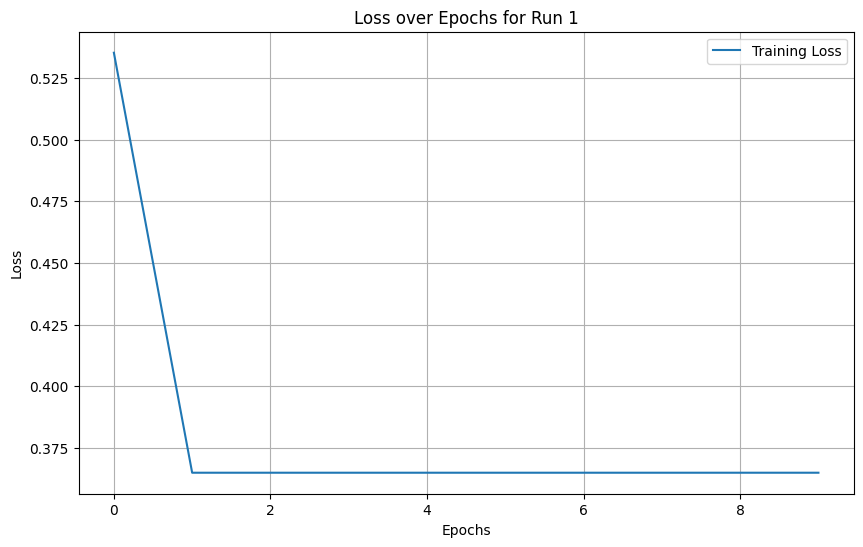

run_folder: /content/DATA/run_2/original_result


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207 (828.00 B)

 Trainable params: 207 (828.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.0312 - loss: 1.0804
Epoch 1 ended
Loss: 0.6257343292236328, Accuracy: 0.6899999976158142
Learning Rate: 5.0
Layer 1 Weights: [[ 13.582344    13.1249695  -12.564508    13.075167   -12.795002
  -12.471875   -12.563851   -13.058534    -0.4028291  -12.789138  ]
 [ 13.140699   -13.430489   -13.278526    13.144651   -12.913588
  -13.438333   -12.808283   -12.530954     0.4540499  -13.224096  ]
 [ 13.152882   -13.15611    -13.638088    13.256984   -13.525627
  -13.459259   -12.513444   -13.474453    -0.35097772 -13.385576  ]
 [ 12.736806   -12.447146   -12.457628    12.756016   -13.297037
  -13.601122    -9.915981   -12.848862    -0.07981962 -12.69486   ]
 [ 13.209595   -13.2288     -12.511427    13.587853   -12.638331
  -13.098412   -11.752766   -12.584299    -0.32354778 -13.366313  ]
 [ 13.205846   -12.454629   -13.163985    13.520716   -12.757662
  -12.869786   -11.3333235  -13.458243    -0.5438744  -13.270529  ]]
Layer 1 Biases:

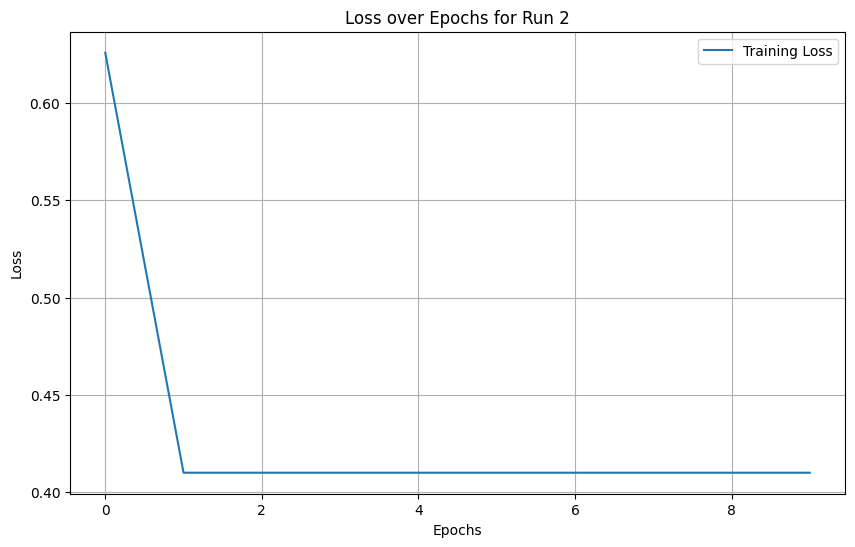

run_folder: /content/DATA/run_3/original_result


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207 (828.00 B)

 Trainable params: 207 (828.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 1.0000 - loss: 0.9039
Epoch 1 ended
Loss: 0.5692482590675354, Accuracy: 1.0
Learning Rate: 5.0
Layer 1 Weights: [[ 13.38858     13.206427    12.871164     4.1032643    0.03243005
  -12.70233    -12.491677   -12.680555    13.137987   -12.82991   ]
 [ 13.511041   -12.817309    13.478137     7.6282725   -0.5167843
  -12.596244    12.94436    -13.00792     12.874924   -13.1092    ]
 [ 12.91344    -12.872906    12.775378     4.9924693   -0.2567465
  -13.401436   -13.312763   -12.802374    12.368944   -12.557425  ]
 [ 13.572279   -12.551374    12.835852     5.1825757   -0.3987161
  -12.981247    12.828688   -12.957668    12.461325   -13.073036  ]
 [ 13.397842    12.352515    13.659643     0.3754406    0.04104543
  -13.016597    13.144924   -12.678867    13.546568   -13.179291  ]
 [ 13.260896    12.411084    12.511926     7.6412926    0.2891739
  -13.505801    13.2936535  -13.317607    12.878802   -13.499483  ]]
Layer 1 Biases: [ 13.0

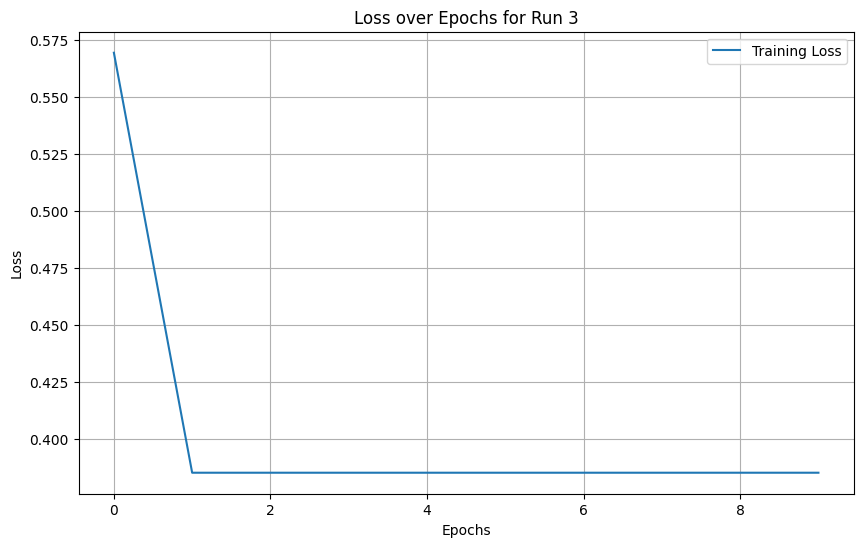

run_folder: /content/DATA/run_4/original_result


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207 (828.00 B)

 Trainable params: 207 (828.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3750 - loss: 1.1286
Epoch 1 ended
Loss: 0.6061678528785706, Accuracy: 0.800000011920929
Learning Rate: 5.0
Layer 1 Weights: [[ 1.51725411e-02 -1.27815132e+01 -5.70627451e-01 -1.31015091e+01
   1.36574516e+01 -4.45825934e-01  1.35217743e+01 -1.26800146e+01
   1.24218969e+01 -1.30471430e+01]
 [-3.05377394e-01 -1.25373383e+01 -4.89435107e-01  1.33987665e+01
   1.27358160e+01 -5.79496264e-01  1.33210983e+01 -1.30385542e+01
   1.27139235e+01 -1.28053370e+01]
 [-1.02790058e-01 -1.30415201e+01  8.57365727e-02  1.33854418e+01
   1.26692886e+01  1.20871007e-01  1.31459265e+01 -1.25128345e+01
   1.27155914e+01 -1.29631634e+01]
 [-2.13140845e-02 -1.31640568e+01 -5.58016002e-01  1.30175953e+01
   1.30679493e+01 -3.83802384e-01  1.32005472e+01 -1.34034233e+01
   1.32448254e+01 -1.24436913e+01]
 [-2.54215598e-02 -1.35534954e+01 -3.00290287e-01 -1.29583797e+01
   1.32855844e+01 -4.63091433e-01  1.24504662e+01 -1.33137493e+01
   1.22396679e+

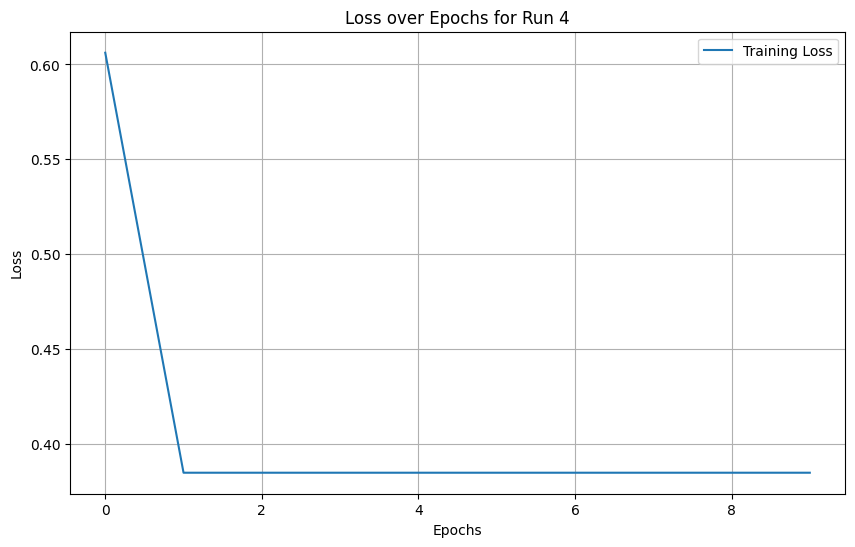

run_folder: /content/DATA/run_5/original_result


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207 (828.00 B)

 Trainable params: 207 (828.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4375 - loss: 1.0094
Epoch 1 ended
Loss: 0.5829929113388062, Accuracy: 0.5
Learning Rate: 5.0
Layer 1 Weights: [[ 1.32639713e+01  1.31128874e+01 -1.35135956e+01 -1.29622993e+01
   1.31059303e+01  1.25227814e+01 -1.34134941e+01 -1.29685993e+01
  -1.03060305e-01 -1.27705021e+01]
 [ 1.36229944e+01  1.32797508e+01 -1.30534096e+01 -1.26983852e+01
  -1.34360485e+01  1.24348660e+01 -1.25892143e+01 -1.31021805e+01
  -1.02872252e-02 -1.34700298e+01]
 [ 1.25933371e+01  1.36090527e+01 -1.30649757e+01 -1.25123119e+01
   1.21189594e+01  1.29050083e+01 -1.32300224e+01 -1.29939251e+01
  -2.26402253e-01 -1.33955059e+01]
 [ 1.33256464e+01  1.30437841e+01 -1.25041685e+01 -1.33943224e+01
  -1.26604137e+01  1.33828869e+01 -1.31771240e+01 -1.27426805e+01
  -5.79387605e-01 -1.34418707e+01]
 [ 1.33544064e+01  1.25042791e+01 -1.27848587e+01 -1.33241081e+01
   1.28749561e+01  1.30499153e+01 -1.26247540e+01 -1.27696075e+01
  -5.47566295e-01 -1.25215168

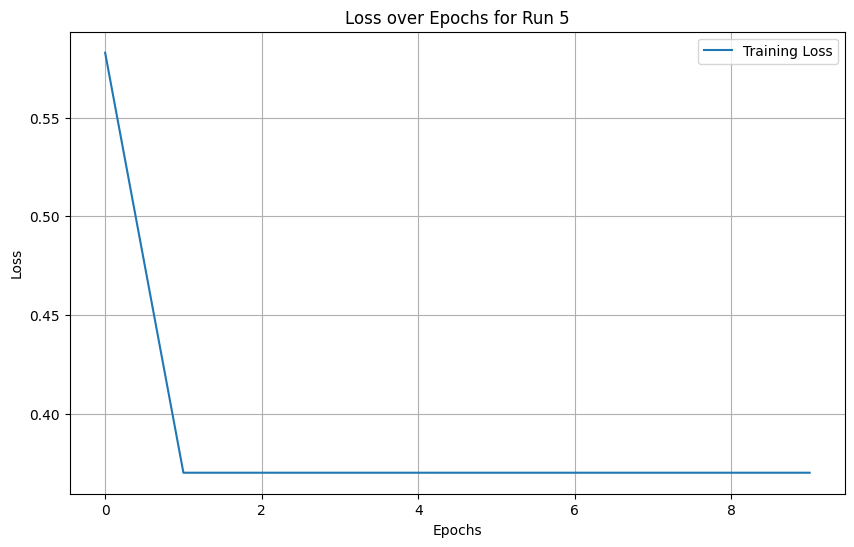

In [ ]:
# Train the traditional /content/DATA/run_1/original_result/x_train.npy

network_setting = input("Do you want to modify the traditional network setup? (yes/no): ").strip().lower()

# Default parameters
hidden_layers_TN = None
hidden_num_neurons_TN = None
epochs_TN = None

if network_setting == 'yes':
  hidden_layers_TN = int(input("Enter the number of hidden layers for the traditional network: "))
  hidden_num_neurons_TN = [int(input(f"Enter the number of neurons for hidden layer {i+1}: ")) for i in range(hidden_layers_TN)]
  epochs_TN = int(input("Enter the number of epochs for the traditional network: "))

# Initialize a list to store the errors for each run
errors = []
for run_number in range(1, num_runs + 1):
    # Define the run folder based on run number
    # run_folder = os.path.join(base_folder, f"run_{run_number}")
    run_folder = f"/content/{base_folder}/run_{run_number}/original_result"
    print(f"run_folder: {run_folder}")

    # Load data and parameters for the current run
    num_training_inputs, lower_bound, max_lower_bound, upper_bound, min_lower_bound, func_expressions, num_layers, num_neurons, num_input_neurons, output_num_neurons, epochs, bias_learning_rate, tau_learning_rate, bias_values, tau_values, x_train, y_train = load_run_data(run_folder, base_folder)

    # Determine parameters for the traditional network (use modified if set, otherwise default to custom values)
    epochs_to_use = epochs_TN if epochs_TN else epochs
    hidden_layers_to_use = hidden_layers_TN if hidden_layers_TN else num_layers - 1  # Subtract input/output layers
    hidden_neurons_to_use = hidden_num_neurons_TN if hidden_num_neurons_TN else num_neurons[1:]  # Middle layers

    # Initialize the traditional neural network with specified or default parameters
    traditional_nn = create_traditional_nn(
        input_dim=num_input_neurons,
        output_dim=output_num_neurons,
        hidden_layers=hidden_layers_to_use,
        neurons_per_layer=hidden_neurons_to_use,
        learning_rate=bias_learning_rate
    )

    # Initialize a custom logger to track progress
    custom_logger = CustomLogger()

     # Train the traditional network and store the error for each run
    history = traditional_nn.fit(x_train, y_train, epochs=epochs_to_use, callbacks=[custom_logger])

    # Store the final loss (error) for the current run
    final_loss = history.history['loss'][-1]
    errors.append(final_loss)

    # Plot the loss over epochs for this run
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss over Epochs for Run {run_number}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Print combined summary
print("\nRun Comparison:")
headers = ["Run", "Custom Model Error", "Traditional Model Error"]
table = []

for run_number in range(num_runs):
    table.append([
        run_number + 1,
        former_run_summary[run_number][1],
        errors[run_number]
    ])

print(tabulate(table, headers, tablefmt="grid"))


Run Comparison:
+-------+----------------------+---------------------------+
|   Run |   Custom Model Error |   Traditional Model Error |
+=======+======================+===========================+
|     1 |                 0.37 |                     0.365 |
+-------+----------------------+---------------------------+
|     2 |                 0.42 |                     0.41  |
+-------+----------------------+---------------------------+
|     3 |                 0.39 |                     0.385 |
+-------+----------------------+---------------------------+
|     4 |                 0.39 |                     0.385 |
+-------+----------------------+---------------------------+
|     5 |                 0.38 |                     0.37  |
+-------+----------------------+---------------------------+


# **To Download a Folder**

In [ ]:
import shutil
import os
from IPython.display import display
from google.colab import files

# This will compress the folder into a zip file and offer it for download

def download_folder(base_folder, zip_name):
    """
    Compresses the specified run folder into a zip file for download.

    Parameters:
    base_folder (str): The base folder where the run folders are located.
    zip_name (str): The name of the output zip file (without extension).
    """

    # Ask user for the run number
    run_number = input("Enter the run number to download: ")
    folder_path = os.path.join(base_folder, f"run_{run_number}")

    # Ensure the folder exists
    if os.path.exists(folder_path):
        zip_path = shutil.make_archive(zip_name, 'zip', base_folder, f"run_{run_number}")
        print(f"Folder '{folder_path}' has been compressed into '{zip_name}.zip'.")

        # Trigger download
        files.download(f"{zip_name}.zip")
        print(f"Folder '{zip_name}' downloded in your local directory.")
    else:
        print(f"Folder '{folder_path}' not found.")

# Base folder path where the run folders are located, e.g., '/content/DATA'
base_folder = '/content/DATA'
# Zip file name
zip_name = 'downloaded_run_folder'

download_folder(base_folder, zip_name)


KeyboardInterrupt: Interrupted by user

In [ ]:
5

In [ ]:
# import numpy as np
# import sympy as sp

# # Function to check if the operation is logical (like AND/OR)
# def is_logical_operation(func_str):
#     logical_ops = ['&', '|', 'and', 'or']  # Add any other logical operators you want to support
#     return any(op in func_str for op in logical_ops)

# # Ask user for number of inputs
# num_inputs = int(input("Enter the number of inputs (dimension): "))

# # Ask user for range for input variable
# lower_bound = float(input("Enter the lower bound of input range: "))
# upper_bound = float(input("Enter the upper bound of input range: "))

# # Ask user for the number of training inputs in the dataset
# num_training_inputs = int(input("Enter the number of training inputs in the dataset: "))

# # Create X_train dataset with random values uniformly between the bounds
# X_train = np.random.uniform(lower_bound, upper_bound, (num_training_inputs, num_inputs))
# # print("\nX_train:")
# # print(X_train)
# # print(X_train.dtype, X_train.shape)
# X_train = [
#     [0.27, 0.80],
#     [0.82, 0.64],
#     [0.16, 0.65],
#     [0.57, 0.10],
#     [0.12, 0.84],
#     [0.83, 0.93],
#     [0.61, 0.39],
#     [0.44, 0.62],
#     [0.63, 0.13],
#     [0.45, 0.73]
# ]

# X_train = np.array(X_train)
# print("\nX_train:")
# print(X_train)
# print("")
# print(X_train.dtype, X_train.shape)

# # Ask user for number of outputs
# num_outputs = int(input("\nEnter the number of outputs: "))

# # Create y_train by asking user to provide functions for each output
# y_train = []
# x_symbols = sp.symbols(f'x0:{num_inputs}')  # Creates symbols x0, x1, x2, ..., up to num_inputs
# print('x_symbols: ', x_symbols)  # Debug statement

# for i in range(num_outputs):
#     # Ask user for the function
#     func_str = input(f"Enter y_train({i + 1}) function using symbols x0, x1, x2, ...(use '&' for AND, '|' for OR): ")
#     print(f"\nfunc_str: {func_str}")


#     if is_logical_operation(func_str):
#         # Apply thresholding if the function is a logical operation
#         binary_x_train = (X_train > 0.5).astype(int)  # Convert to binary values based on threshold
#         print(f"Binary X_train for y_train({i + 1}):\n{binary_x_train}")  # Debug statement

#         # Log the function string

#         func = sp.sympify(func_str)  # Convert string to sympy expression
#         print ('func :',  func)
#         func_callable = sp.lambdify(x_symbols, func, 'numpy')  # Convert to callable

#         # Evaluate the function for each row
#         y_values = np.array([func_callable(*binary_x_train[row]) for row in range(num_training_inputs)])
#         print ('y_values before converting to binary:',  y_values)

#         # Convert boolean results to binary (0 and 1)
#         y_values = y_values.astype(int)
#         print ('y_values after converting to binary:',  y_values)
#         print(f"Type of y_values: {type(y_values)}")


#         # Debugging output
#         # for row in range(num_training_inputs):
#         #     print(f"Evaluating row {row}: X = {binary_x_train[row]}, Output = {y_values[row]}")  # Debug statement

#     else:
#         # For mathematical functions, apply directly on continuous values
#         func = sp.sympify(func_str)  # Convert string to sympy expression
#         func_callable = sp.lambdify(x_symbols, func, 'numpy')  # Convert to callable
#         y_values = np.array([func_callable(*X_train[row]) for row in range(num_training_inputs)])

#         # Debugging output
#         for row in range(num_training_inputs):
#             print(f"Evaluating row {row}: X = {X_train[row]}, Output = {y_values[row]}")  # Debug statement

#     # Append results to y_train
#     y_train.append(y_values)

# # Convert y_train to numpy array and transpose to match the format (num_training_inputs, num_outputs)
# y_train = np.array(y_train).T

# print("\ny_train:")
# print(y_train)